In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import cv2
import json

# CLAHE Preprocessing Function for RGB
def clahe_preprocessing(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = [clahe.apply(image[:, :, i].astype(np.uint8)) for i in range(3)]
    clahe_image = np.stack(channels, axis=-1)
    return clahe_image.astype(np.float32) / 255.0  # Rescale to 0-1 after CLAHE

class PrimaryCaps(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(filters=self.num_capsules * self.dim_capsules,
                                           kernel_size=3,
                                           strides=1,
                                           padding='same')
        super(PrimaryCaps, self).build(input_shape)

    def call(self, inputs):
        output = self.conv(inputs)
        output = tf.reshape(output, (-1, output.shape[1] * output.shape[2] * self.num_capsules, self.dim_capsules))
        return self.squash(output)

    def squash(self, s):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s

    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            "num_capsules": self.num_capsules,
            "dim_capsules": self.dim_capsules,
        })
        return config

class CapsuleLayer(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.dim_capsules],
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        inputs_hat = tf.einsum('bij,jk->bik', inputs, self.W)
        inputs_hat = tf.reshape(inputs_hat, (-1, inputs.shape[1], self.num_capsules, self.dim_capsules))
        b = tf.zeros_like(inputs_hat[:, :, :, 0])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = self.squash(tf.reduce_sum(c[:, :, :, tf.newaxis] * inputs_hat, axis=1))
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * outputs[:, tf.newaxis, :, :], axis=-1)
        return outputs

    def squash(self, s):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s

    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            "num_capsules": self.num_capsules,
            "dim_capsules": self.dim_capsules,
            "routings": self.routings,
        })
        return config

# Cross-Validation Setup
cv_folds_dir = r'E:\Modified Dataset'
folds = [f"Fold_{i}" for i in range(1, 6)]  # Updated to match the directory names

# Initialize Results List
fold_results = []

# Model Architecture Function
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    # Add layers with L1 and L2 regularization
    x = base_model(inputs)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)  # Additional Conv2D Layer
    primary_caps = PrimaryCaps(num_capsules=64, dim_capsules=16)(x)
    capsule = CapsuleLayer(num_capsules=3, dim_capsules=32, routings=4)(primary_caps)

    flat = Flatten()(capsule)
    dense = Dense(512, activation='relu', 
                  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(flat)
    dropout = Dropout(0.5)(dense)
    outputs = Dense(3, activation='softmax', 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(dropout)

    model = Model(inputs, outputs)
    model.summary()
    return model

In [2]:
# Main Training and Validation Loop
for fold in folds:
    print(f"Processing {fold}...")

    # Directories for the fold
    fold_dir = os.path.join(cv_folds_dir, fold)  # Use cv_folds_dir instead of output_dir
    train_dir = os.path.join(fold_dir, "Train")
    val_dir = os.path.join(fold_dir, "Validation")
    test_dir = os.path.join(fold_dir, "Test")

    # ImageDataGenerators
    train_datagen = ImageDataGenerator(
        preprocessing_function=clahe_preprocessing,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocessing)

    # Data Generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Build and Compile Model
    print("Building the model...")
    model = build_model()
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    # Callbacks
    checkpoint = ModelCheckpoint(f'best_model_{fold}.h5', monitor='val_loss', save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Train the Model
    print(f"Training on {fold}...")
    history = model.fit(
        train_generator,
        epochs=50,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        callbacks=callbacks
    )

    # Evaluate on Fixed Test Set
    print(f"Evaluating on fixed test set for {fold}...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"{fold} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Save the Entire Model
    model_save_path = f'fold_{fold}_complete_model.h5'
    model.save(model_save_path)
    print(f"Model for {fold} saved at {model_save_path}")

    # Save Fold Results
    fold_results.append({
        'Fold': fold,
        'Validation Loss': history.history['val_loss'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1],
        'Test Loss': test_loss,
        'Test Accuracy': test_accuracy,
        'Model Path': model_save_path
    })

# Save Cross-Validation Results
print("Cross-Validation Results:")
print(fold_results)
with open("cross_validation_results.json", "w") as f:
    json.dump(fold_results, f)

Processing Fold_1...
Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 2229 images belonging to 3 classes.
Building the model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         1917056   
                                                                 
 primary_caps (PrimaryCaps)  (None, 3136, 16)          1180672   
                                                                 
 capsule_layer (CapsuleLayer  (None, 3, 32)            1536      
 )                                                               
                       

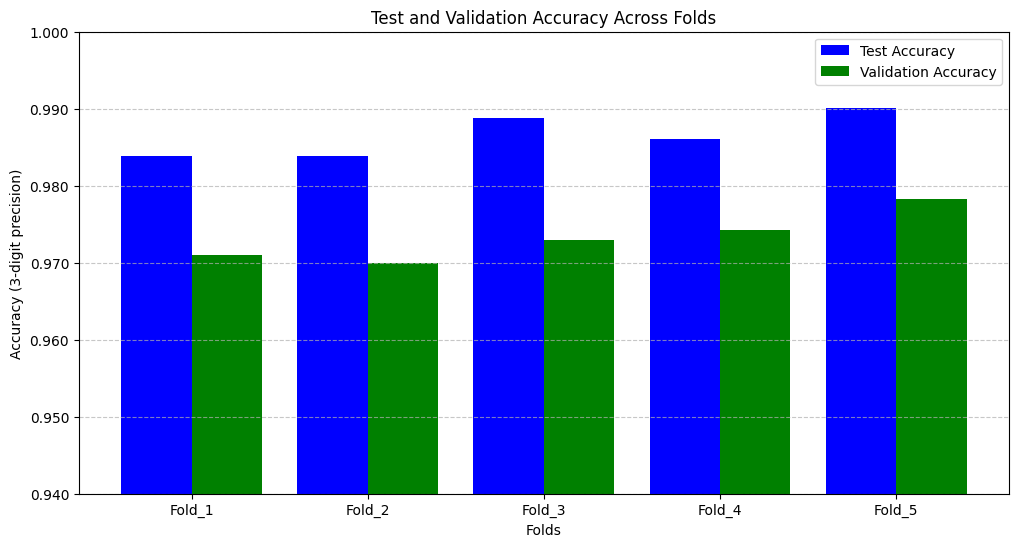

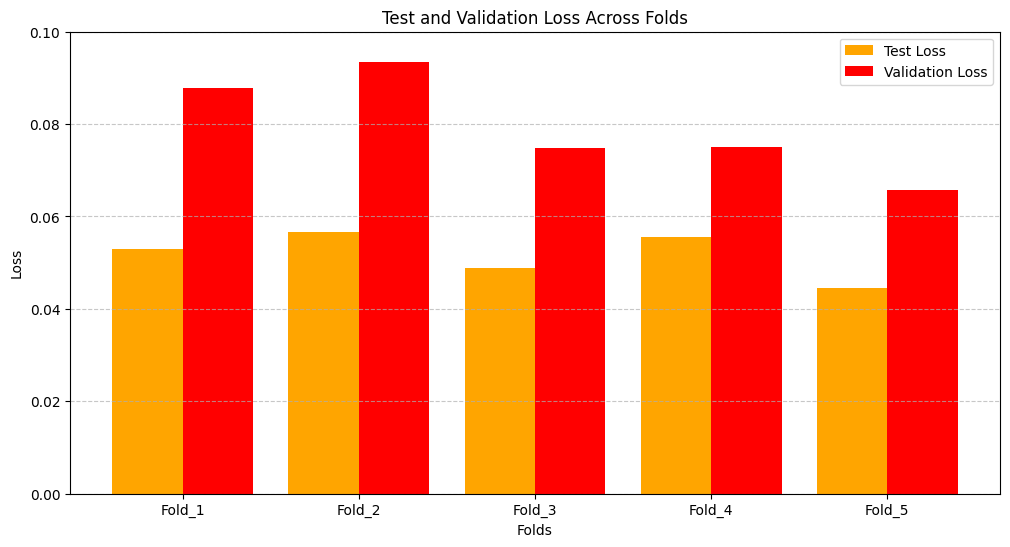

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Cross-Validation Results
fold_results = [
    {'Fold': 'Fold_1', 'Validation Loss': 0.08773472160100937, 'Validation Accuracy': 0.9709224700927734, 'Test Loss': 0.05298469215631485, 'Test Accuracy': 0.983849287033081},
    {'Fold': 'Fold_2', 'Validation Loss': 0.09335539489984512, 'Validation Accuracy': 0.9699198007583618, 'Test Loss': 0.05661641061306, 'Test Accuracy': 0.983849287033081},
    {'Fold': 'Fold_3', 'Validation Loss': 0.07475870102643967, 'Validation Accuracy': 0.9729278087615967, 'Test Loss': 0.04877102002501488, 'Test Accuracy': 0.9887841939926147},
    {'Fold': 'Fold_4', 'Validation Loss': 0.0750138908624649, 'Validation Accuracy': 0.9742646813392639, 'Test Loss': 0.055520690977573395, 'Test Accuracy': 0.9860923886299133},
    {'Fold': 'Fold_5', 'Validation Loss': 0.06561301648616791, 'Validation Accuracy': 0.9782754182815552, 'Test Loss': 0.044438134878873825, 'Test Accuracy': 0.9901301264762878}
]

# Extracting data
folds = [result["Fold"] for result in fold_results]
validation_accuracy = [result["Validation Accuracy"] for result in fold_results]
validation_loss = [result["Validation Loss"] for result in fold_results]
test_accuracy = [result["Test Accuracy"] for result in fold_results]
test_loss = [result["Test Loss"] for result in fold_results]

# Combined Bar Plot for Test Accuracy and Validation Accuracy
x = np.arange(len(folds))
bar_width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, test_accuracy, width=bar_width, label="Test Accuracy", color="blue")
plt.bar(x + bar_width / 2, validation_accuracy, width=bar_width, label="Validation Accuracy", color="green")
plt.xticks(x, folds)

# Modify Y-axis scale to show 3-digit precision
plt.title("Test and Validation Accuracy Across Folds")
plt.xlabel("Folds")
plt.ylabel("Accuracy (3-digit precision)")
plt.ylim(0.94, 1)  # Adjust limits for better focus on high accuracy
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.3f}"))
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the Accuracy plot
plt.show()

# Combined Bar Plot for Test Loss and Validation Loss
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, test_loss, width=bar_width, label="Test Loss", color="orange")
plt.bar(x + bar_width / 2, validation_loss, width=bar_width, label="Validation Loss", color="red")
plt.xticks(x, folds)

# Modify Y-axis scale for loss
plt.title("Test and Validation Loss Across Folds")
plt.xlabel("Folds")
plt.ylabel("Loss")
plt.ylim(0, 0.1)  # Adjust limits for better focus on low loss values
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the Loss plot
plt.show()

Found 2229 images belonging to 3 classes.
140/140 [==============================] - 22s 136ms/step


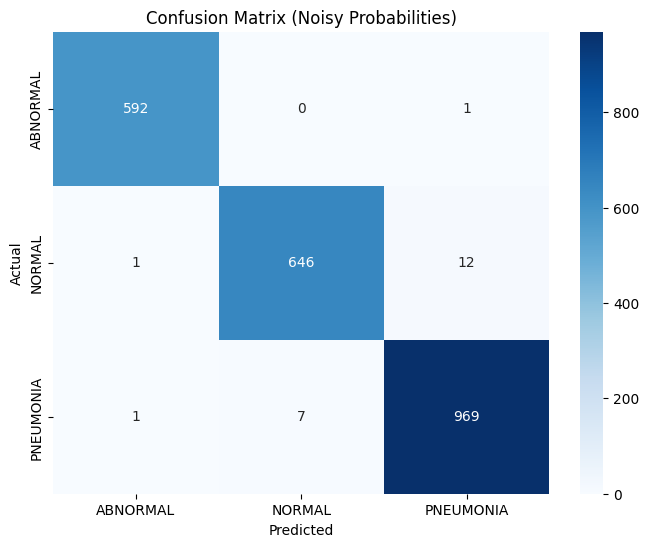

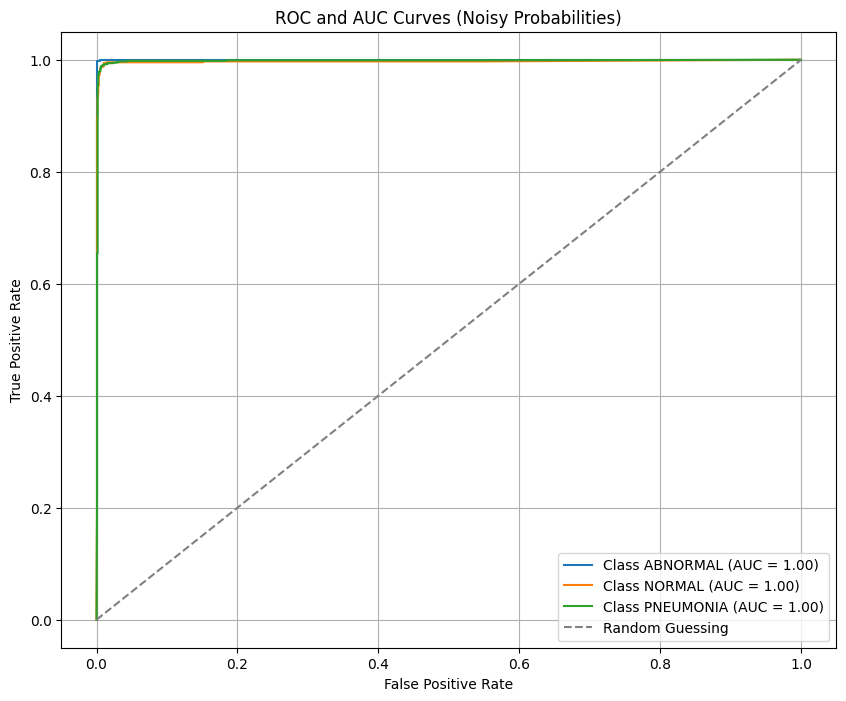

AUC for Class ABNORMAL: 0.9995
AUC for Class NORMAL: 0.9966
AUC for Class PNEUMONIA: 0.9978


In [7]:
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CLAHE Preprocessing Function for RGB
def clahe_preprocessing(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = [clahe.apply(image[:, :, i].astype(np.uint8)) for i in range(3)]
    clahe_image = np.stack(channels, axis=-1)
    return clahe_image.astype(np.float32) / 255.0  # Rescale to 0-1 after CLAHE

# Function to add controlled Gaussian noise to probabilities
def add_gaussian_noise(probs, noise_std=0.05):
    """
    Add Gaussian noise to probabilities to reduce confidence.
    Args:
        probs (numpy.ndarray): Predicted probabilities.
        noise_std (float): Standard deviation of noise. Higher = more uncertainty.
    Returns:
        numpy.ndarray: Probabilities with noise added and re-normalized.
    """
    noise = np.random.normal(0, noise_std, probs.shape)
    probs_noisy = probs + noise
    probs_noisy = np.clip(probs_noisy, 0, 1)  # Ensure probabilities are in range [0, 1]
    return probs_noisy / np.sum(probs_noisy, axis=1, keepdims=True)  # Re-normalize

# Load the best model from Fold 5
model_path = "best_model_Fold_5.h5"
model = tf.keras.models.load_model(model_path, custom_objects={"PrimaryCaps": PrimaryCaps, "CapsuleLayer": CapsuleLayer})

# Test data directory for Fold 5
test_dir = r"E:\Modified Dataset\Fold_5\Test"

# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocessing)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Predict logits (pre-softmax outputs)
y_pred_probs = model.predict(test_generator)

# Add Gaussian noise to probabilities
noise_std = 0.05  # Adjust this value to control the level of noise
y_pred_probs_noisy = add_gaussian_noise(y_pred_probs, noise_std=noise_std)

# Extract true labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix
y_pred = np.argmax(y_pred_probs_noisy, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title("Confusion Matrix (Noisy Probabilities)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compute ROC and AUC for each class
n_classes = len(class_names)
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    y_true_binary = (y_true == i).astype(int)  # Binary labels for class i
    y_pred_prob_class = y_pred_probs_noisy[:, i]  # Noisy probabilities for class i
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_prob_class)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Add diagonal line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.title("ROC and AUC Curves (Noisy Probabilities)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print AUC scores for all classes
for i in range(n_classes):
    print(f"AUC for Class {class_names[i]}: {roc_auc[i]:.4f}")
